In [16]:
from datasets import Dataset
from gpn.data import GenomeMSA
from gpn.msa.inference import run_inference
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from scipy.spatial.distance import cdist
from scipy.stats import zscore
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
TRAIN_CHROMS = ["1"]
D = 768

In [3]:
cols = ["chrom", "pos", "ref", "alt"]


def match_columns(df, target, covariates):
    pos = df[df[target]]
    neg = df[~df[target]]
    D = cdist(pos[covariates], neg[covariates])

    closest = []
    dists = []
    for i in tqdm(range(len(pos))):
        D[i, neg.chrom != pos.iloc[i].chrom] = np.inf  # ensure picking from same chrom
        j = np.argmin(D[i])
        closest.append(j)
        D[:, j] = np.inf  # ensure it cannot be picked up again
    return pd.concat([pos, neg.iloc[closest]])

In [4]:
ldscore = pd.read_parquet("../../results/tmp/ldscore.processed.parquet")
ldscore

,chrom,pos,ref,alt,AF,ld_score
0,1,11063,T,G,0.000048,5.738593
1,1,13259,G,A,0.000278,5.048821
2,1,17641,G,A,0.000831,1.683291
3,1,57222,T,C,0.000659,2.475932
4,1,58396,T,C,0.00024,29.534102
...,...,...,...,...,...,...
22153592,X,155697134,G,A,0.000028,28.358136
22153593,X,155697920,G,A,0.302726,406.085388
22153594,X,155699751,C,T,0.245915,483.126375
22153595,X,155700569,A,G,0.246325,484.684299


In [5]:
ldscore["MAF"] = ldscore['AF'].apply(lambda x: min(x, 1-x))

In [6]:
pips = pd.read_parquet("../../results/tmp/my_pips.parquet")
pips

,chrom,pos,ref,alt,trait,method,pip,region,maf,LD_HWE,LD_SV
0,1,820055,T,G,IGF1,SUSIE,0.001039,chr1:708908-3708908,0.005550,False,False
1,1,832873,A,C,IGF1,SUSIE,0.003492,chr1:708908-3708908,0.236748,False,False
2,1,833068,G,A,CRP,SUSIE,0.004263,chr1:64194-3064194,0.106004,False,False
3,1,834583,G,A,CRP,SUSIE,0.004209,chr1:64194-3064194,0.105298,False,False
4,1,835506,G,A,CRP,SUSIE,0.004478,chr1:64194-3064194,0.104339,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4763178,22,50783624,G,A,Mono,SUSIE,0.001769,chr22:48513402-51304566,0.300835,False,False
4763179,22,50784537,G,A,Mono,SUSIE,0.001520,chr22:48513402-51304566,0.304649,False,False
4763180,22,50790482,G,A,Mono,SUSIE,0.003555,chr22:48513402-51304566,0.299990,False,False
4763181,22,50791289,A,T,Mono,SUSIE,0.003565,chr22:48513402-51304566,0.296184,False,False


In [7]:
pips = pips[(~pips.LD_HWE) & (~pips.LD_SV)]
pips

,chrom,pos,ref,alt,trait,method,pip,region,maf,LD_HWE,LD_SV
0,1,820055,T,G,IGF1,SUSIE,0.001039,chr1:708908-3708908,0.005550,False,False
1,1,832873,A,C,IGF1,SUSIE,0.003492,chr1:708908-3708908,0.236748,False,False
2,1,833068,G,A,CRP,SUSIE,0.004263,chr1:64194-3064194,0.106004,False,False
3,1,834583,G,A,CRP,SUSIE,0.004209,chr1:64194-3064194,0.105298,False,False
4,1,835506,G,A,CRP,SUSIE,0.004478,chr1:64194-3064194,0.104339,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4763178,22,50783624,G,A,Mono,SUSIE,0.001769,chr22:48513402-51304566,0.300835,False,False
4763179,22,50784537,G,A,Mono,SUSIE,0.001520,chr22:48513402-51304566,0.304649,False,False
4763180,22,50790482,G,A,Mono,SUSIE,0.003555,chr22:48513402-51304566,0.299990,False,False
4763181,22,50791289,A,T,Mono,SUSIE,0.003565,chr22:48513402-51304566,0.296184,False,False


In [8]:
# option 1
pips = pips[pips.method=="SUSIE"]

# option 2
#pips = pips.groupby(["chrom", "pos", "ref", "alt", "trait"]).agg({"method": "nunique", "pip": "mean", "maf": "mean"}).reset_index()
#pips = pips[pips.method==2]

pips

,chrom,pos,ref,alt,trait,method,pip,region,maf,LD_HWE,LD_SV
0,1,820055,T,G,IGF1,SUSIE,0.001039,chr1:708908-3708908,0.005550,False,False
1,1,832873,A,C,IGF1,SUSIE,0.003492,chr1:708908-3708908,0.236748,False,False
2,1,833068,G,A,CRP,SUSIE,0.004263,chr1:64194-3064194,0.106004,False,False
3,1,834583,G,A,CRP,SUSIE,0.004209,chr1:64194-3064194,0.105298,False,False
4,1,835506,G,A,CRP,SUSIE,0.004478,chr1:64194-3064194,0.104339,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4763178,22,50783624,G,A,Mono,SUSIE,0.001769,chr22:48513402-51304566,0.300835,False,False
4763179,22,50784537,G,A,Mono,SUSIE,0.001520,chr22:48513402-51304566,0.304649,False,False
4763180,22,50790482,G,A,Mono,SUSIE,0.003555,chr22:48513402-51304566,0.299990,False,False
4763181,22,50791289,A,T,Mono,SUSIE,0.003565,chr22:48513402-51304566,0.296184,False,False


In [9]:
# option 1
#pips_agg = pips.groupby(cols).agg({"pip": "sum", "maf": "mean", "trait": "count"}).reset_index().rename(columns={"trait": "n_traits"})
#pips_agg["pip"] = pips_agg.pip / len(pips.trait.unique())  # average pip

# option 2
pips_agg = pips.groupby(cols).agg({"pip": "max", "maf": "mean"}).reset_index()

pips_agg

,chrom,pos,ref,alt,pip,maf
0,1,820055,T,G,0.001039,0.005550
1,1,832873,A,C,0.003492,0.236748
2,1,833068,G,A,0.004263,0.106004
3,1,834583,G,A,0.004209,0.105298
4,1,835506,G,A,0.004478,0.104339
...,...,...,...,...,...,...
1632740,9,138172038,C,T,0.001342,0.372683
1632741,9,138173218,G,A,0.045044,0.165755
1632742,9,138174172,T,C,0.001422,0.372984
1632743,9,138174508,T,C,0.001392,0.399574


In [10]:
models = [
    "CADD.RawScore",
    "phyloP",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]
embedding_model = models[-1]


model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",    
}

V = pd.read_parquet("../../results/finemapping/processed/test.parquet")
d = Path(f"../../results/preds/results/finemapping/processed")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,CADD,phyloP,GPN-MSA
0,1,832873,A,C,0.145778,0.677,0.546393
1,1,833068,G,A,0.016390,-0.036,1.718937
2,1,834583,G,A,0.051453,0.479,0.066588
3,1,835506,G,A,0.177210,0.645,-0.150484
4,1,841852,C,T,0.025537,0.459,-0.040198
...,...,...,...,...,...,...,...
1821943,22,50783624,G,A,-0.438139,0.932,-0.719305
1821944,22,50784537,G,A,-0.645151,-0.249,0.157599
1821945,22,50790482,G,A,0.020462,-0.349,0.066454
1821946,22,50791289,A,T,-0.261473,-0.062,-0.829577


In [11]:
V = pd.concat([
    V,
    pd.read_parquet(f"../../results/preds/vep_embedding/results/finemapping/processed/{embedding_model}.parquet")
], axis=1)
V

,chrom,pos,ref,alt,CADD,phyloP,GPN-MSA,embedding_0,embedding_1,embedding_2,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,1,832873,A,C,0.145778,0.677,0.546393,327.407166,168.603760,310.369537,...,118.821938,476.082916,47.642521,243.169952,83.901390,106.842987,136.855988,267.079407,190.964325,57.205971
1,1,833068,G,A,0.016390,-0.036,1.718937,147.760559,159.395966,356.285278,...,81.839973,298.484619,29.851658,157.940964,64.164658,51.969040,37.594158,250.187012,81.586136,78.551956
2,1,834583,G,A,0.051453,0.479,0.066588,138.471649,344.457458,653.160828,...,175.601807,160.399094,47.566139,124.103378,55.504795,83.486725,116.397141,133.027679,98.886223,68.059204
3,1,835506,G,A,0.177210,0.645,-0.150484,119.532608,69.242371,267.720459,...,139.702240,292.348816,60.947781,120.855606,31.584688,57.365559,38.881702,149.588074,30.385689,96.709305
4,1,841852,C,T,0.025537,0.459,-0.040198,236.072586,83.557465,235.280548,...,139.943115,330.970093,31.695229,142.334061,34.199543,43.387611,52.077309,140.667084,35.862450,67.422905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821943,22,50783624,G,A,-0.438139,0.932,-0.719305,88.744247,112.298386,295.139404,...,137.403030,222.140106,49.977669,77.113968,35.358963,59.509201,118.620300,78.555145,54.243546,112.973755
1821944,22,50784537,G,A,-0.645151,-0.249,0.157599,303.820862,243.325348,276.309204,...,122.213409,515.731323,58.894569,212.943604,86.336014,111.217133,217.519592,256.985840,251.811249,83.490044
1821945,22,50790482,G,A,0.020462,-0.349,0.066454,271.307465,216.114197,311.271118,...,130.699799,495.617188,44.539875,209.166031,85.865372,95.644203,232.313690,241.816727,246.717041,92.467789
1821946,22,50791289,A,T,-0.261473,-0.062,-0.829577,215.936768,281.264648,494.794708,...,225.337997,308.721039,45.186890,135.191132,101.618546,105.227776,160.207275,173.959747,251.927643,78.020370


In [12]:
V = V.merge(ldscore, on=cols, how="inner")
V

,chrom,pos,ref,alt,CADD,phyloP,GPN-MSA,embedding_0,embedding_1,embedding_2,...,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,AF,ld_score,MAF
0,1,832873,A,C,0.145778,0.677,0.546393,327.407166,168.603760,310.369537,...,243.169952,83.901390,106.842987,136.855988,267.079407,190.964325,57.205971,0.763689,65.233773,0.236311
1,1,833068,G,A,0.016390,-0.036,1.718937,147.760559,159.395966,356.285278,...,157.940964,64.164658,51.969040,37.594158,250.187012,81.586136,78.551956,0.105508,39.035791,0.105508
2,1,834583,G,A,0.051453,0.479,0.066588,138.471649,344.457458,653.160828,...,124.103378,55.504795,83.486725,116.397141,133.027679,98.886223,68.059204,0.104803,39.16434,0.104803
3,1,835506,G,A,0.177210,0.645,-0.150484,119.532608,69.242371,267.720459,...,120.855606,31.584688,57.365559,38.881702,149.588074,30.385689,96.709305,0.103867,38.977357,0.103867
4,1,841852,C,T,0.025537,0.459,-0.040198,236.072586,83.557465,235.280548,...,142.334061,34.199543,43.387611,52.077309,140.667084,35.862450,67.422905,0.095105,39.579469,0.095105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816798,22,50783624,G,A,-0.438139,0.932,-0.719305,88.744247,112.298386,295.139404,...,77.113968,35.358963,59.509201,118.620300,78.555145,54.243546,112.973755,0.299913,38.986375,0.299913
1816799,22,50784537,G,A,-0.645151,-0.249,0.157599,303.820862,243.325348,276.309204,...,212.943604,86.336014,111.217133,217.519592,256.985840,251.811249,83.490044,0.30374,39.121952,0.303740
1816800,22,50790482,G,A,0.020462,-0.349,0.066454,271.307465,216.114197,311.271118,...,209.166031,85.865372,95.644203,232.313690,241.816727,246.717041,92.467789,0.299102,37.73791,0.299102
1816801,22,50791289,A,T,-0.261473,-0.062,-0.829577,215.936768,281.264648,494.794708,...,135.191132,101.618546,105.227776,160.207275,173.959747,251.927643,78.020370,0.295325,37.576431,0.295325


In [13]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

GPN-MSA


In [14]:
not_na = ~V[models].isna().any(axis=1)
not_na.mean()

0.9887593756725412

In [15]:
V = V[not_na]
V.shape

(1796381, 778)

In [17]:
V2 = V.merge(pips_agg, how="inner", on=cols).sort_values("pip", ascending=False)
V2["maf_z"] = zscore(V2["maf"])
V2["ld_score_z"] = zscore(V2["ld_score"].astype(float))

# option 1
#V2.loc[V2.pip.rank(ascending=False) <= 1000, "Likely causal"] = True   # 1000
#V2.loc[V2.pip.rank() <= 100_000, "Likely causal"] = False  # 100_000

# option 2
V2.loc[V2.pip > 0.99, "Likely causal"] = True
V2.loc[V2.pip < 0.01, "Likely causal"] = False

V2 = V2.dropna(subset="Likely causal")
V2["Likely causal"] = V2["Likely causal"].astype(bool)
V2["Likely causal"].value_counts()

Likely causal
False    1248001
True        1460
Name: count, dtype: int64

In [18]:
V2 = match_columns(
    V2, "Likely causal",
    [
        "maf_z",
        "ld_score_z"
    ]
)
V2 = V2.drop_duplicates()
V2["Likely causal"].value_counts()

100%|██████████| 1460/1460 [02:21<00:00, 10.34it/s]


Likely causal
True     1460
False    1460
Name: count, dtype: int64

In [19]:
mask_train = V2.chrom.isin(TRAIN_CHROMS)
V_train = V2[mask_train].copy()
V_test = V2[~mask_train].copy()
len(V_train), len(V_test)

(298, 2622)

In [20]:
features = [f"embedding_{i}" for i in range(D)]
results_train = pd.DataFrame([
    [f"embedding_{i}", roc_auc_score(V_train["Likely causal"], -V_train[f"embedding_{i}"])]
    for i in tqdm(range(D))
], columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
results_train

100%|██████████| 768/768 [00:01<00:00, 547.46it/s]


,Model,AUROC
684,embedding_684,0.742129
541,embedding_541,0.739426
748,embedding_748,0.737174
454,embedding_454,0.732985
597,embedding_597,0.730373
...,...,...
530,embedding_530,0.276924
71,embedding_71,0.275483
248,embedding_248,0.273051
565,embedding_565,0.270348


In [21]:
sorted_indices = results_train.Model.values
sorted_indices[:10]

array(['embedding_684', 'embedding_541', 'embedding_748', 'embedding_454',
       'embedding_597', 'embedding_243', 'embedding_695', 'embedding_217',
       'embedding_132', 'embedding_276'], dtype=object)

In [22]:
V_test["inner_product_select_dimensions"] = V_test[sorted_indices[:10]].sum(axis=1)
models.append("inner_product_select_dimensions")

In [29]:
#n = len(V2)//2

n_pos, n_neg = V_test["Likely causal"].sum(), (~V_test["Likely causal"]).sum()
subtitle = f"n={n_pos} vs. {n_neg}"


results = []
for m in models:
    results.append([
        m,
        roc_auc_score(V_test["Likely causal"], -V_test[m]),
        #average_precision_score(V2["Likely causal"], -V2[m]),
        #np.mean([(V2.iloc[i][m] < V2.iloc[i+n][m]) for i in range(n)]),
    ])
results = pd.DataFrame(results, columns=[
    "Model",
    "AUROC",
    #"AUPRC",
    #"Pairwise_accuracy"
])
results

,Model,AUROC
0,CADD,0.697107
1,phyloP,0.645999
2,GPN-MSA,0.680010
3,inner_product_select_dimensions,0.759265


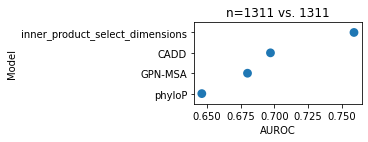

In [30]:
plt.figure(figsize=(3,1.5))
sns.pointplot(
    data=results.sort_values("AUROC", ascending=False),
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);